In [1]:
%matplotlib notebook
import pandas as pd
import numpy as np
#from sklearn.model_selection import train_test_split as tts
#from sklearn.ensemble import ExtraTreesClassifier as ExTC
from pprint import pprint
#from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
R2 = pd.read_csv('./surrogate_performance/R^2.csv', index_col=0)
features = pd.read_csv('./features/benchmark.csv', index_col=0)

In [3]:
cv_max = pd.read_csv('./surrogate_performance/benchmarkCV-score-max.csv', index_col=0)
cv_mean = pd.read_csv('./surrogate_performance/benchmarkCV-score-mean.csv', index_col=0)

In [4]:
# Drop NANs
features.dropna(axis = 1, inplace=True)

# Drop columns with only one unique value
cols = features.select_dtypes([np.number]).columns
std = features[cols].std()
cols_to_drop = std[std==0].index
features = features.drop(cols_to_drop, axis=1)

# Drop columns with inf
features.replace([np.inf, -np.inf], np.nan, inplace=True)
features.dropna(axis = 1, inplace=True)

In [5]:
# Calculating Loss and Targets. Target is the modelling method with lowest loss.
loss = -R2.sub(R2.max(axis=1), axis=0)
targets = loss.idxmin(axis=1)

In [6]:
# Getting data that is avalable in both targets and features
features_available_for = targets.index.intersection(features.index)
targets = targets.loc[features_available_for]

In [7]:
# Doing the same for cv_max and cv_mean

cv_max = cv_max.loc[features_available_for]
cv_mean = cv_mean.loc[features_available_for]
cv_mean_best = cv_mean.idxmax(axis=1)
cv_max_best = cv_max.idxmax(axis=1)

In [8]:
loss_CVmax = pd.DataFrame(columns=['CVmax'], index=features_available_for, dtype=float)
for comp_id in features_available_for:
    loss_CVmax['CVmax'].at[comp_id] = loss[cv_max_best.loc[comp_id]].loc[comp_id]

    
loss_CVmean = pd.DataFrame(columns=['CVmean'], index=features_available_for, dtype=float)
for comp_id in features_available_for:
    loss_CVmean['CVmean'].at[comp_id] = loss[cv_mean_best.loc[comp_id]].loc[comp_id]

In [9]:
columns = {'ProblemName':0, 'num_var':1, 'num_samples':2, 'distribution':3}

characteristics = pd.DataFrame(index=features_available_for, columns=columns)

In [10]:
for index in characteristics.index:
    for column in columns:
        characteristics[column][index] = index.split('.')[0].split('_')[columns[column]]
characteristics['num_var'] = characteristics['num_var'].astype(int)
characteristics['num_samples'] = characteristics['num_samples'].astype(int)

In [11]:
CV_data = characteristics.join(loss_CVmax).join(loss_CVmean)
CV_data.head()

,ProblemName,num_var,num_samples,distribution,CVmax,CVmean
DTLZ4_16_250_normal.csv,DTLZ4,16,250,normal,1.309035e-10,1.309035e-10
WFG1_30_900_uniform.csv,WFG1,30,900,uniform,-0.000000e+00,-0.000000e+00
DTLZ5_6_1200_normal.csv,DTLZ5,6,1200,normal,-0.000000e+00,-0.000000e+00
DTLZ1_16_1500_uniform.csv,DTLZ1,16,1500,uniform,-0.000000e+00,-0.000000e+00
WFG1_20_200_uniform.csv,WFG1,20,200,uniform,-0.000000e+00,-0.000000e+00


<IPython.core.display.Javascript object>


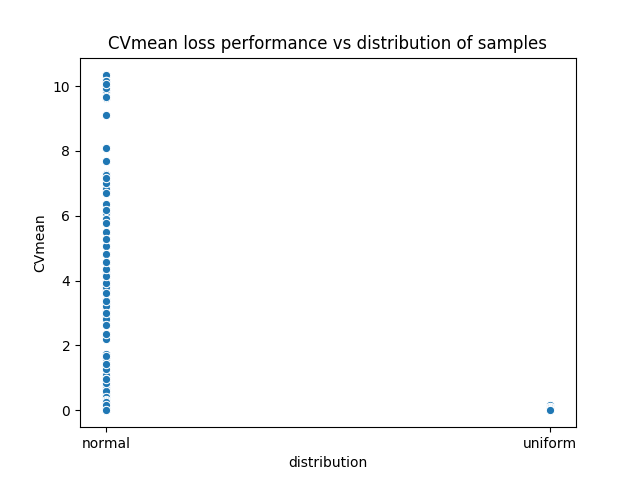

Text(0.5, 1.0, 'CVmean loss performance vs distribution of samples')

In [12]:
sns.scatterplot(x='distribution', y='CVmean', data=CV_data)
plt.title('CVmean loss performance vs distribution of samples')

<IPython.core.display.Javascript object>


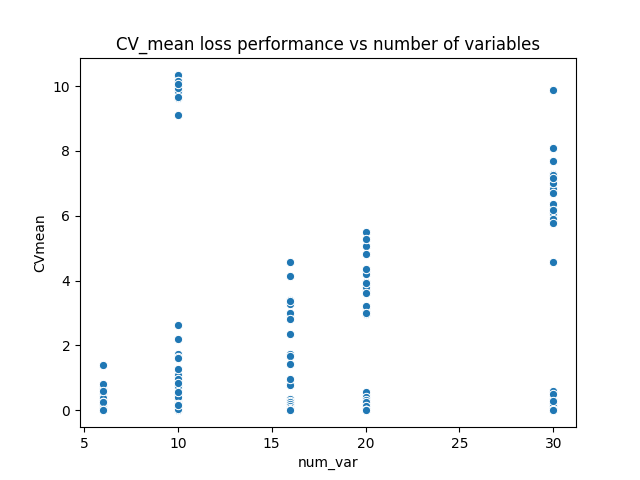

Text(0.5, 1.0, 'CV_mean loss performance vs number of variables')

In [13]:
sns.scatterplot(x='num_var', y='CVmean', data=CV_data)
plt.title('CV_mean loss performance vs number of variables')

<IPython.core.display.Javascript object>


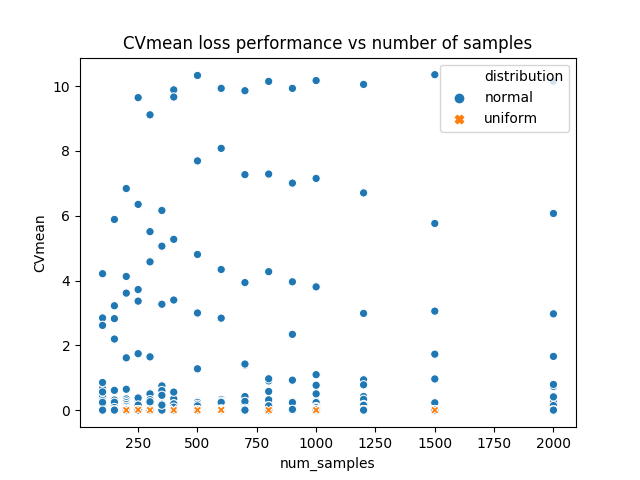

In [14]:
sns.scatterplot(x='num_samples', y='CVmean', hue='distribution', style='distribution', data=CV_data)
plt.title('CVmean loss performance vs number of samples')
plt.legend(loc='upper right')

<IPython.core.display.Javascript object>


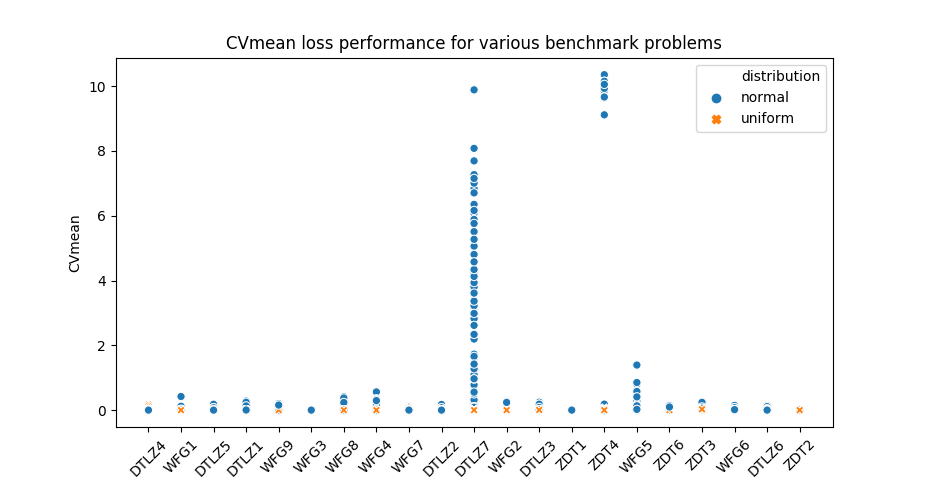

Text(0.5, 1.0, 'CVmean loss performance for various benchmark problems')

In [15]:
sns.scatterplot(x='ProblemName', y='CVmean', hue='distribution', style='distribution', data=CV_data)
#sns.boxplot(x='ProblemName', y='CVmean', data=CV_data[CV_data['distribution']=='uniform'])
#sns.catplot(x='ProblemName', y='CVmean',row='distribution', kind='box', data=CV_data)
plt.xticks(rotation=45)
plt.title('CVmean loss performance for various benchmark problems')

<IPython.core.display.Javascript object>


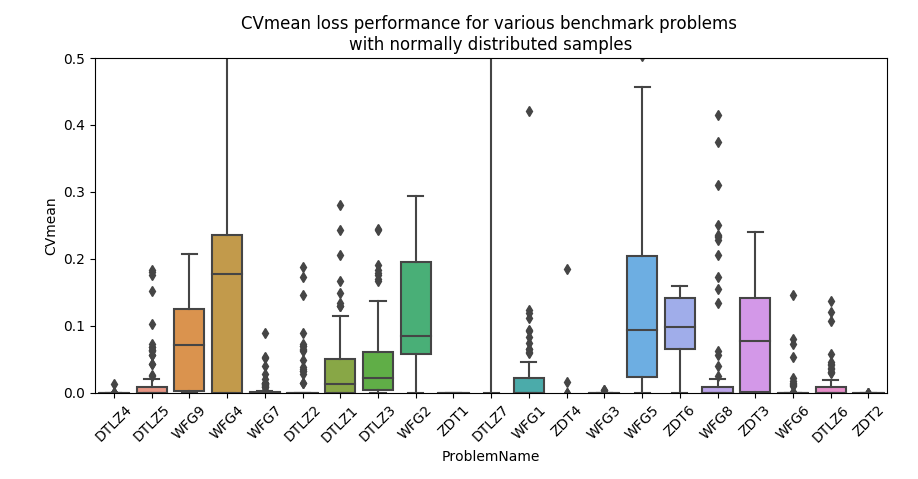

In [16]:
#sns.scatterplot(x='ProblemName', y='CVmean', hue='distribution', style='distribution', data=CV_data)
sns.boxplot(x='ProblemName', y='CVmean', data=CV_data[CV_data['distribution']=='normal'])
plt.xticks(rotation=45)
plt.ylim([0,0.5])
plt.title('CVmean loss performance for various benchmark problems \nwith normally distributed samples')
plt.tight_layout()

In [17]:
CV_normal_data = CV_data[CV_data['distribution']=='normal']

In [18]:
CV_normal_data = CV_normal_data.join(features)

<IPython.core.display.Javascript object>


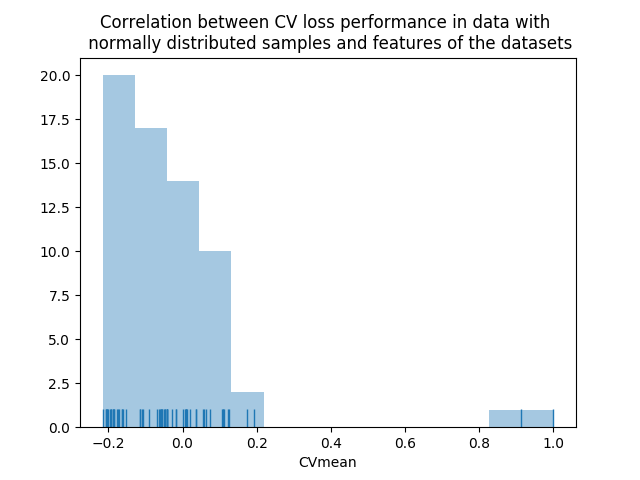

Text(0.5, 1.0, 'Correlation between CV loss performance in data with \n normally distributed samples and features of the datasets')

In [19]:
sns.distplot(CV_normal_data.corr()['CVmean'], kde=False, rug=True)
plt.title('Correlation between CV loss performance in data with \n normally distributed samples and features of the datasets')

In [20]:
CV_corr = CV_normal_data.corr()

<IPython.core.display.Javascript object>


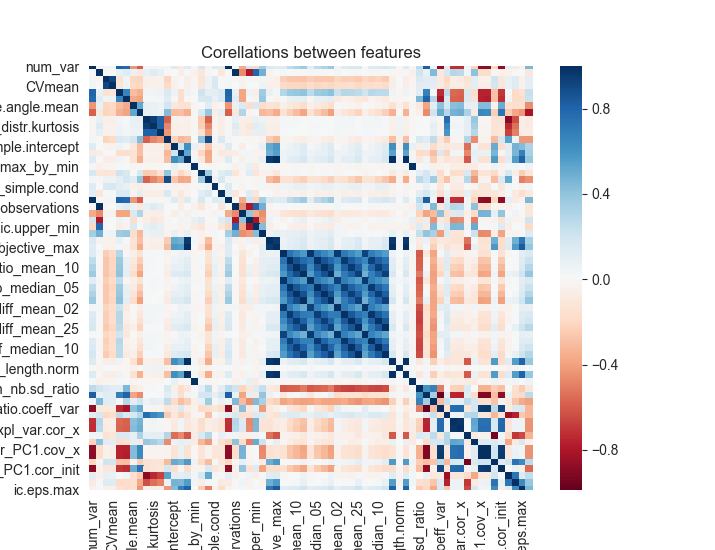

Text(0.5, 1, 'Corellations between features')

In [21]:
sns.set_style("whitegrid")
sns.heatmap(CV_corr,cmap="RdBu")
#plt.tight_layout()
plt.title('Corellations between features')

In [22]:
CV_corr_09 = CV_corr[(CV_corr>0.9) | (CV_corr<-0.9)].replace(np.nan,0)
CV_corr_09[CV_corr_09.sum(axis=1)>1]
corr = dict()
for column in CV_corr_09.columns:
    col_corr = CV_corr_09[column]
    correllated_columns = col_corr[(col_corr!=0) & (col_corr!=1)].index.tolist()
    if not correllated_columns:
        continue
    else:
        corr[column] = correllated_columns

In [23]:
pprint(corr)

{'CVmax': ['CVmean'],
 'CVmean': ['CVmax'],
 'basic.objective_max': ['ela_meta.lin_simple.coef.max',
                         'basic.objective_min',
                         'limo.avg_length.reg',
                         'limo.length.mean'],
 'basic.objective_min': ['ela_meta.lin_simple.coef.max',
                         'basic.objective_max',
                         'limo.avg_length.reg',
                         'limo.length.mean'],
 'disp.diff_mean_02': ['disp.ratio_mean_02',
                       'disp.ratio_median_02',
                       'disp.diff_median_02'],
 'disp.diff_mean_05': ['disp.ratio_mean_05',
                       'disp.ratio_median_05',
                       'disp.diff_median_05'],
 'disp.diff_mean_10': ['disp.ratio_mean_10',
                       'disp.ratio_median_10',
                       'disp.diff_median_10'],
 'disp.diff_mean_25': ['disp.ratio_mean_25',
                       'disp.ratio_median_25',
                       'disp.diff_median_25'],
 '

<IPython.core.display.Javascript object>


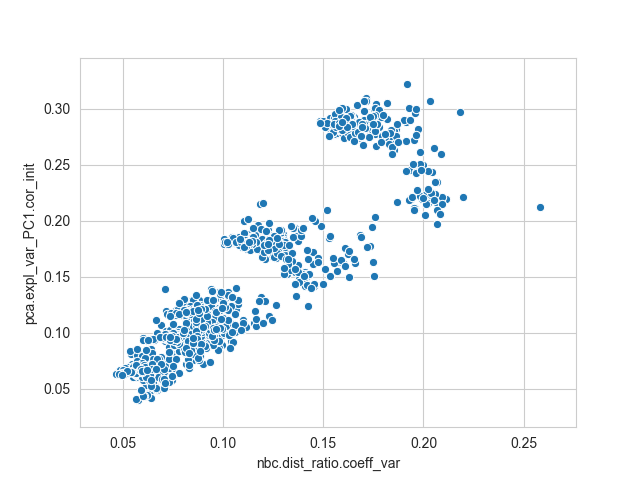

In [24]:
sns.scatterplot(x='nbc.dist_ratio.coeff_var', y='pca.expl_var_PC1.cor_init', data=CV_normal_data)